
Unifying Yearly Surgical Data from 2017 to 2024
This script reads and combines cleaned surgical datasets across 8 years into a single unified DataFrame.
It adds metadata (year, source file name), creates a global patient ID, and saves the merged file for further analysis.
The code loads and merges multi-year Excel data on inpatient bed occupancy (and parallel OR activity), computes admission-discharge intervals to calculate daily bed-occupancy durations and utilization rates, then produces descriptive statistics to characterize historical occupancy patterns—insights that serve as the foundation for building and evaluating the 5-7-day ahead bed-occupancy forecasting model.

In [ ]:
import pandas as pd
from pathlib import Path

excel_files = [
    "/content/2017_data_with_UTR_F.xlsx",
    "/content/2018_data_with_UTR_F.xlsx",
    "/content/2019_data_with_UTR_F.xlsx",
    "/content/2020_data_with_UTR_F.xlsx",
    "/content/2021_data_with_UTR_F.xlsx",
    "/content/2022_data_with_UTR_F.xlsx",
    "/content/2023_data_with_UTR_F.xlsx",
    "/content/2024_data_with_UTR_F.xlsx",
]

# Extract the year from its filename, add metadata, and collect DataFrames
dfs = []
for fp in excel_files:
    df = pd.read_excel(fp)

    # extract year from filename (first part before the underscore)
    file_stem = Path(fp).stem
    year = file_stem.split("_")[0]

    # add metadata columns
    df["year"] = year                                 # year of the record
    df["source_file"] = Path(fp).name                 # original filename

    dfs.append(df)

# Concatenate all DataFrames into one unified DataFrame
df_all = pd.concat(dfs, ignore_index=True, sort=False)

# Create a truly unique ID across all years by combining year and the original ID column
df_all["global_ID"] = df_all["year"] + "_" + df_all["patient_id"].astype(str)

# Optionally add a simple row-based numeric key
df_all["row_id"] = df_all.index + 1

# Save the combined DataFrame to a single Excel file
output_path = "/content/all_years_combined_with_global_ID.xlsx"
df_all.to_excel(output_path, index=False)

print(f"Combined {len(excel_files)} files into {len(df_all)} rows.")
print(f"Saved combined file to: {output_path}")

Combined 8 files into 98422 rows.
Saved combined file to: /content/all_years_combined_with_global_ID.xlsx


In [ ]:
util_cols = [c for c in df_all.columns if "daily_utilization_rate" in c]
print("Available util columns:", util_cols)

Available util columns: ['daily_utilization_rate']


Included years: [np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


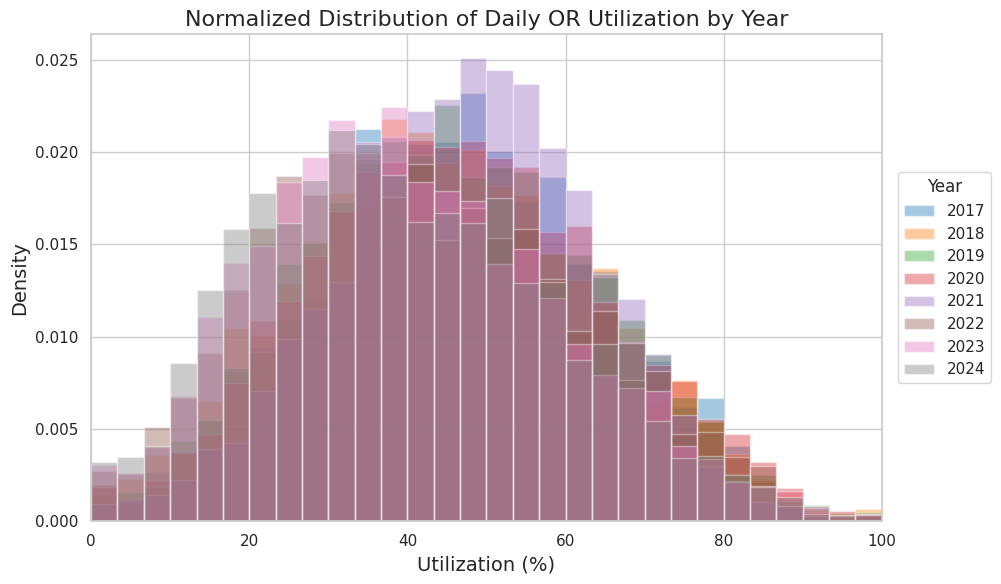

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from pathlib import Path

file_pattern = "/content/*_data_with_UTR_F.xlsx"
files = glob(file_pattern)
df_list = []

for fp in files:
    year = int(Path(fp).stem.split("_")[0])
    df = pd.read_excel(fp)
    df["year"] = year
    df_list.append(df)

df_all = pd.concat(df_list, ignore_index=True, sort=False)
print("Included years:", sorted(df_all["year"].unique()))

assert "daily_utilization_rate" in df_all.columns, "Column not found: daily_utilization_rate"

sns.set_theme(style="whitegrid")

# Plot normalized histograms by year
plt.figure(figsize=(12, 6))

years = sorted(df_all["year"].unique())
colors = plt.get_cmap("tab10").colors
palette = {y: colors[i % len(colors)] for i, y in enumerate(years)}

for y in years:
    vals = df_all.loc[df_all["year"] == y, "daily_utilization_rate"].dropna()
    plt.hist(
        vals,
        bins=30,
        density=True,
        alpha=0.4,
        label=str(y),
        color=palette[y]
    )

plt.title("Normalized Distribution of Daily OR Utilization by Year", fontsize=16)
plt.xlabel("Utilization (%)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim(0, 100)

plt.legend(
    title="Year",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0
)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [ ]:
# How many records per year vs. how many with valid occupancy_hours?
import pandas as pd

df_all["entry_dt"] = pd.to_datetime(
    df_all["Actual Surgery Room Entry Date"].astype(str) + " " +
    df_all["Actual Surgery Room Entry Time"].astype(str),
    errors="coerce"
)
df_all["exit_dt"] = pd.to_datetime(
    df_all["End of Surgery Date (Exit from OR)"].astype(str) + " " +
    df_all["End of Surgery Time (Exit from OR)"].astype(str),
    errors="coerce"
)
df_all["occupancy_hours"] = (df_all["exit_dt"] - df_all["entry_dt"]).dt.total_seconds() / 3600

counts    = df_all.groupby("year").size().rename("total_rows")
with_hours = df_all.groupby("year")["occupancy_hours"].apply(lambda x: x.notna().sum()).rename("with_hours")

summary = pd.concat([counts, with_hours], axis=1)
print(summary)

      total_rows  with_hours
year                        
2017       13568       13568
2018       12346       12346
2019       12928       12928
2020       12258       12258
2021       23171       23171
2022       10073       10073
2023        9675        9675
2024        4403        4403


## Statistics and graphs:

In [ ]:
# imports & load combined dataset
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df_all = pd.read_excel("/content/all_years_combined_with_global_ID.xlsx")

# Quick look at structure
print(df_all.shape)
df_all.head()

(98422, 82)


,patient_id,Site Code,Main Surgeon Code,Activity Code,Activity Type Code,Planned SU Time (Large/Medium/Small),Pre-Surgery Patient File (External),Pre-Surgery Admission Date,Height,Weight,...,SU_p_after_limited,SU_p_after_hours,SU_p_limited_hours,Block Duration Hours,SH_r_hours,daily_utilization_rate,year,source_file,global_ID,row_id
0,1,20,"-999, 30817",81.51,15,20.0,23457403,2017-06-08,1.57,63.0,...,0.011968,0.287222,0.671389,5.733333,19.350000,25.519633,2017,2017_data_with_UTR_F.xlsx,2017_1,1
1,2,20,"-999, 18731",65.21,22,20.0,23457802,2017-06-15,1.70,79.0,...,NaN,NaN,1.040278,5.916667,17.833333,26.861371,2017,2017_data_with_UTR_F.xlsx,2017_2,2
2,7,20,"-999, 18796",65.21,22,0.0,23457800,2017-06-15,1.65,76.0,...,0.045833,1.100000,2.679167,1.833333,13.183333,55.467813,2017,2017_data_with_UTR_F.xlsx,2017_7,3
3,9,20,"-999, 31448",65.21,22,20.0,23457631,2017-06-13,1.65,80.0,...,NaN,NaN,0.671389,2.350000,19.350000,25.519633,2017,2017_data_with_UTR_F.xlsx,2017_9,4
4,26,20,"-999, 23054",65.21,22,20.0,23462326,2017-09-12,1.65,56.0,...,NaN,NaN,0.933333,2.750000,6.250000,39.466613,2017,2017_data_with_UTR_F.xlsx,2017_26,5


### Calculation of operating duration:

In [ ]:
#  build entry & exit datetimes, compute occupancy duration
df_all["entry_dt"] = pd.to_datetime(
    df_all["Actual Surgery Room Entry Date"].astype(str) + " " +
    df_all["Actual Surgery Room Entry Time"].astype(str),
    errors="coerce"
)
df_all["exit_dt"] = pd.to_datetime(
    df_all["End of Surgery Date (Exit from OR)"].astype(str) + " " +
    df_all["End of Surgery Time (Exit from OR)"].astype(str),
    errors="coerce"
)

# compute occupancy duration in hours
df_all["occupancy_hours"] = (df_all["exit_dt"] - df_all["entry_dt"]).dt.total_seconds() / 3600

# inspect basic stats
print(df_all["occupancy_hours"].describe())

count    98422.000000
mean         1.502036
std          0.897221
min          0.083333
25%          0.883333
50%          1.300000
75%          1.900000
max         52.204722
Name: occupancy_hours, dtype: float64


Which types of surgery “take” the most time, and which are more stable in terms of duration?

<ipython-input-7-f7c42359a814>:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


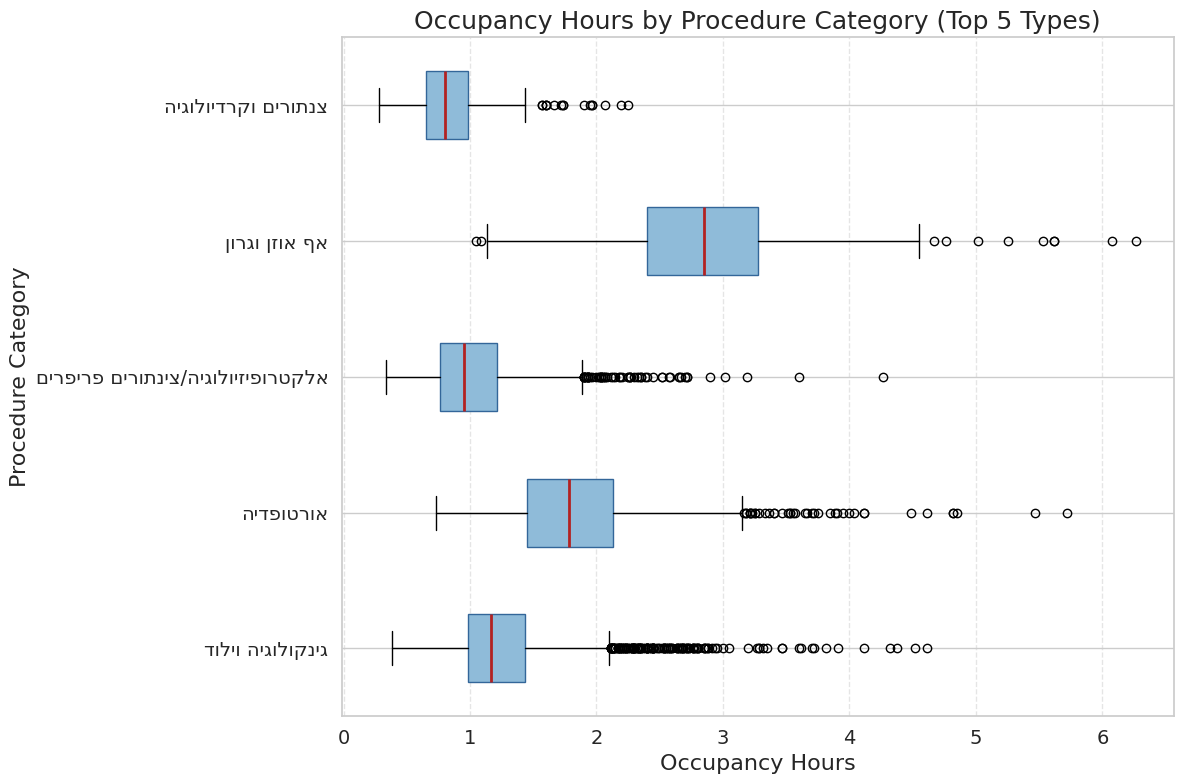

In [ ]:
!pip install python-bidi

import pandas as pd
import matplotlib.pyplot as plt
from bidi.algorithm import get_display

# Load combined data and (re)compute occupancy_hours
df = pd.read_excel("/content/all_years_combined_with_global_ID.xlsx")
df.columns = df.columns.str.strip()

df["entry_dt"] = pd.to_datetime(
    df["Actual Surgery Room Entry Date"].astype(str) + " " +
    df["Actual Surgery Room Entry Time"].astype(str),
    errors="coerce"
)
df["exit_dt"] = pd.to_datetime(
    df["End of Surgery Date (Exit from OR)"].astype(str) + " " +
    df["End of Surgery Time (Exit from OR)"].astype(str),
    errors="coerce"
)
df["occupancy_hours"] = (df["exit_dt"] - df["entry_dt"]).dt.total_seconds() / 3600

#  Merge in Activity Type Name from your mapping file
mapping = pd.read_excel("/content/activity_codes_hg.xlsx")
mapping = mapping.rename(columns={
    "קוד פעילות": "Activity Code",
    "שם סוג פעילות": "Activity Type Name",
})
mapping["Activity Code"] = mapping["Activity Code"].astype(str).str.strip()
df["Activity Code"]     = df["Activity Code"].astype(str).str.strip()

df = df.merge(
    mapping[["Activity Code", "Activity Type Name"]],
    on="Activity Code", how="left"
)

# Select top-5 procedure categories
top5 = df["Activity Type Name"].value_counts().nlargest(5).index.tolist()

# Prepare data arrays & bidi-fix the Hebrew labels
data   = [ df.loc[df["Activity Type Name"] == t, "occupancy_hours"].dropna()
           for t in top5 ]
labels = [ get_display(t) for t in top5 ]

#  Draw the boxplot (with English titles and bidi-fixed Hebrew category labels)
plt.figure(figsize=(12,8))
plt.boxplot(
    data,
    vert=False,
    labels=labels,
    patch_artist=True,
    boxprops=dict(facecolor="#8FBBD9", edgecolor="#336699"),
    medianprops=dict(color="firebrick", linewidth=2)
)

# English title and axes labels
plt.title("Occupancy Hours by Procedure Category (Top 5 Types)", fontsize=18)
plt.xlabel("Occupancy Hours", fontsize=16)
plt.ylabel("Procedure Category", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14, ha="right")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Understand what percentage of analyses have a duration below/above a certain threshold. Especially useful in identifying cutoff points and critical time ranges.

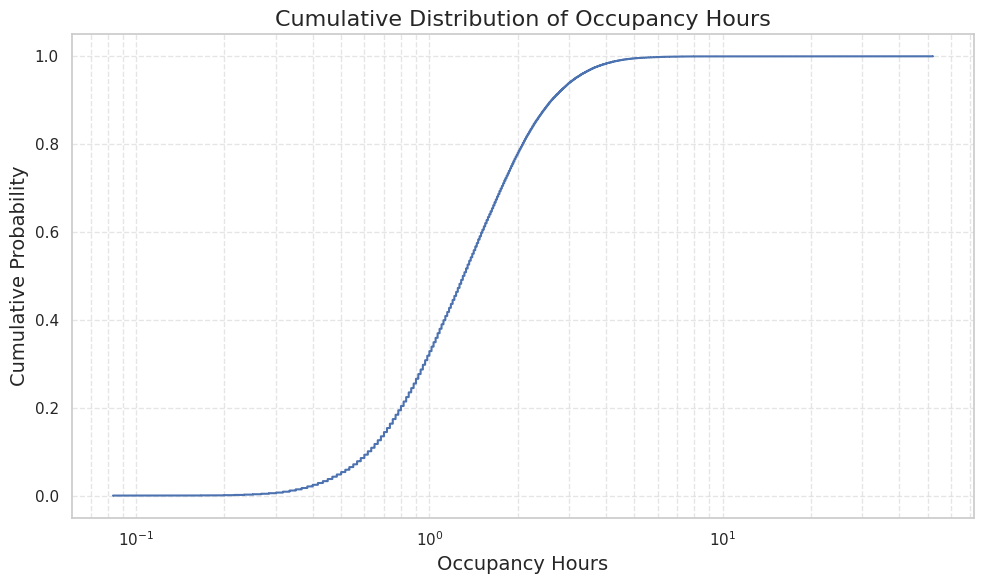

In [ ]:
# CDF of occupancy_hours
import numpy as np
import matplotlib.pyplot as plt

# get sorted non-null values
data = df_all['occupancy_hours'].dropna().sort_values()

# compute CDF values
cdf = np.arange(1, len(data)+1) / len(data)

# plot
plt.figure(figsize=(10,6))
plt.plot(data, cdf, drawstyle='steps-post')
plt.xscale('log')
plt.title('Cumulative Distribution of Occupancy Hours', fontsize=16)
plt.xlabel('Occupancy Hours', fontsize=14)
plt.ylabel('Cumulative Probability', fontsize=14)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# prepare daily utilization using the existing column
# extract calendar date of surgery
df_all["date"] = df_all["entry_dt"].dt.date

# drop duplicates so each OR-date appears once, keeping the original daily_utilization_rate
daily_util = (
    df_all[
        ["Actual Operating Room Number", "date", "daily_utilization_rate"]
    ]
    .drop_duplicates()
)

daily_util.head()

,Actual Operating Room Number,date,daily_utilization_rate
0,20002,2017-06-18,25.519633
1,20009,2017-06-28,26.861371
2,20014,2017-06-18,55.467813
4,20002,2017-09-14,39.466613
5,20014,2017-03-10,44.117712


how utilization varies by day of week.

<ipython-input-10-569590fbb105>:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


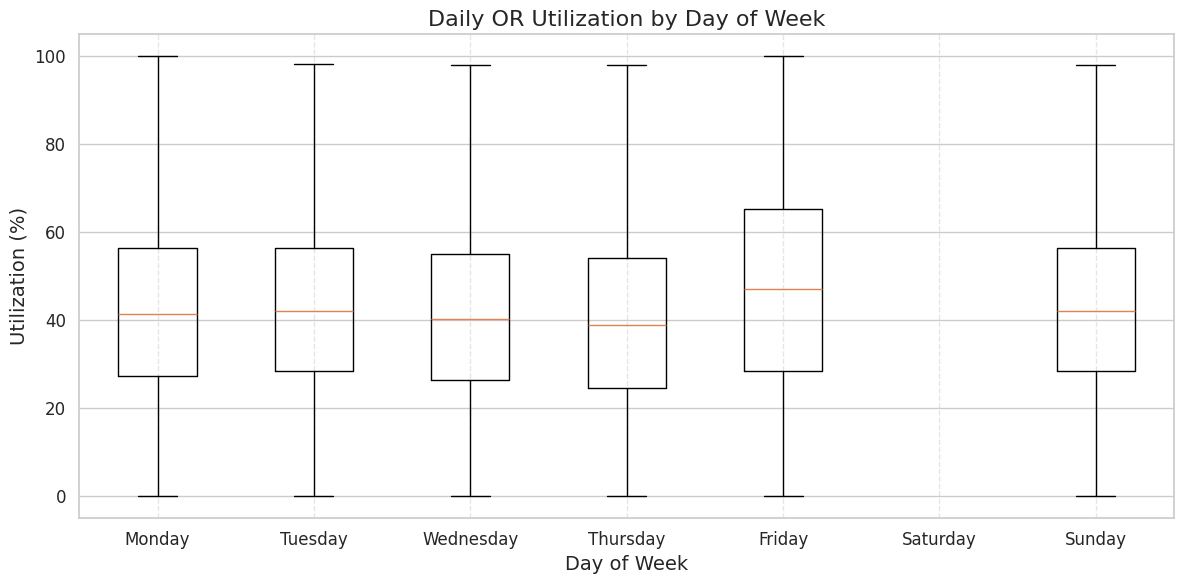

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare daily_util directly from the existing column
df_all["date"] = df_all["entry_dt"].dt.date

daily_util = (
    df_all[
        ["Actual Operating Room Number", "date", "daily_utilization_rate"]
    ]
    .drop_duplicates()
    .rename(columns={"daily_utilization_rate": "util_pct"})
)

# Extract day of week
daily_util["day_of_week"] = pd.to_datetime(daily_util["date"]).dt.day_name()

# Define weekday order
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Plot boxplot using the original utilization column
plt.figure(figsize=(12, 6))

data = [
    daily_util.loc[daily_util["day_of_week"] == d, "util_pct"].dropna()
    for d in order
]

plt.boxplot(data, labels=order, showfliers=False)
plt.title("Daily OR Utilization by Day of Week", fontsize=16)
plt.xlabel("Day of Week", fontsize=14)
plt.ylabel("Utilization (%)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

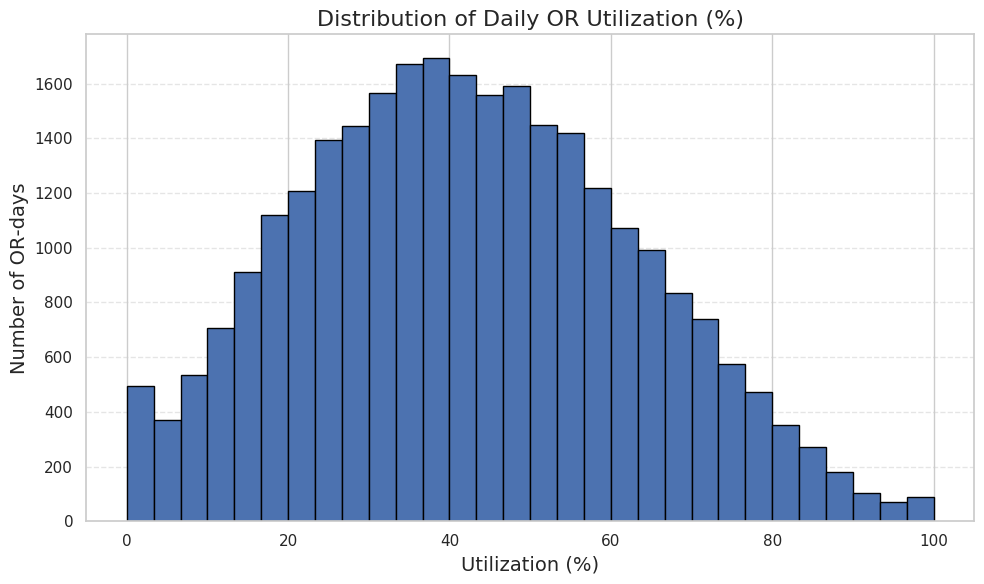

In [ ]:
# Histogram of daily utilization % using the original column
plt.figure(figsize=(10, 6))

daily_util = (
    df_all[
        ["Actual Operating Room Number", "date", "daily_utilization_rate"]
    ]
    .drop_duplicates()
)

# Plot histogram of the original daily_utilization_rate
plt.hist(
    daily_util["daily_utilization_rate"].dropna(),
    bins=30,
    edgecolor="black"
)

plt.title("Distribution of Daily OR Utilization (%)", fontsize=16)
plt.xlabel("Utilization (%)", fontsize=14)
plt.ylabel("Number of OR‐days", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Examining whether there is a trend of increase (or decrease) in OR-day utilization over the years

Identify which operating rooms “deliver” the most in winter/summer, and what seasonality is typical for each OR.

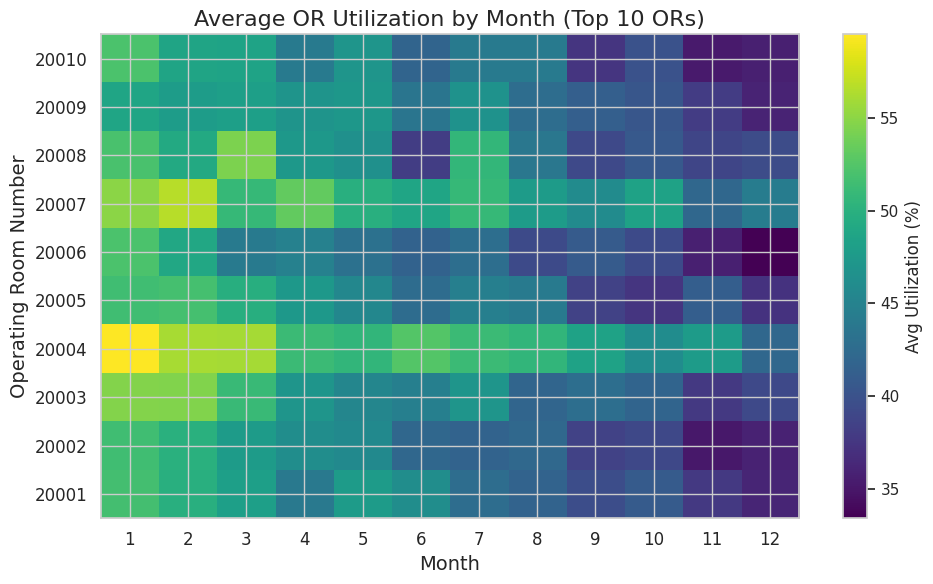

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare daily_util using the original column
daily_util = (
    df_all[["Actual Operating Room Number", "date", "daily_utilization_rate"]]
    .drop_duplicates()
    .rename(columns={"daily_utilization_rate": "util_pct"})
)

# Extract month from date
daily_util["month"] = pd.to_datetime(daily_util["date"]).dt.month

# Identify top-10 busiest ORs by mean utilization
top10 = (
    daily_util
    .groupby("Actual Operating Room Number")["util_pct"]
    .mean()
    .nlargest(10)
    .index
    .tolist()
)

# Pivot for heatmap: ORs × months → mean util_pct
heatmap_data = (
    daily_util[daily_util["Actual Operating Room Number"].isin(top10)]
    .pivot_table(
        index="Actual Operating Room Number",
        columns="month",
        values="util_pct",
        aggfunc="mean"
    )
)

# Plot heatmap
plt.figure(figsize=(10, 6))
plt.imshow(heatmap_data, aspect="auto", cmap="viridis", origin="lower")
plt.colorbar(label="Avg Utilization (%)")

# Y-axis: OR numbers
plt.yticks(
    range(len(heatmap_data.index)),
    heatmap_data.index,
    fontsize=12
)

# X-axis: months
plt.xticks(
    range(len(heatmap_data.columns)),
    heatmap_data.columns,
    fontsize=12
)

plt.title("Average OR Utilization by Month (Top 10 ORs)", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Operating Room Number", fontsize=14)

plt.tight_layout()
plt.show()

Included years: [np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


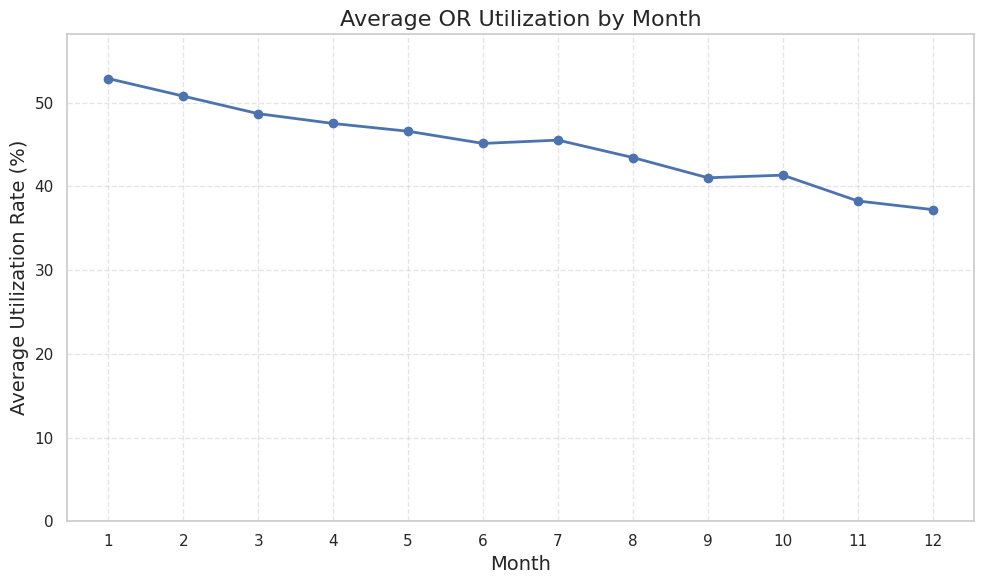

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path

file_pattern = "/content/*_data_with_UTR_F.xlsx"
files = glob(file_pattern)
df_list = []

for fp in files:
    year = int(Path(fp).stem.split("_")[0])
    df = pd.read_excel(fp)
    df["year"] = year

    # build entry datetime & extract calendar date
    df["entry_dt"] = pd.to_datetime(
        df["Actual Surgery Room Entry Date"].astype(str) + " " +
        df["Actual Surgery Room Entry Time"].astype(str),
        errors="coerce"
    )
    df["date"] = df["entry_dt"].dt.date

    df_list.append(df)

df_all = pd.concat(df_list, ignore_index=True, sort=False)
print("Included years:", sorted(df_all["year"].unique()))

# Ensure the original utilization column exists
assert "daily_utilization_rate" in df_all.columns, "Column not found: daily_utilization_rate"

# Seasonality: extract month
df_all["month"] = pd.to_datetime(df_all["date"]).dt.month

# Compute average of the original daily_utilization_rate by month
monthly_trend = (
    df_all
    .groupby("month")["daily_utilization_rate"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 6))
plt.plot(
    monthly_trend["month"],
    monthly_trend["daily_utilization_rate"],
    marker="o",
    linewidth=2
)
plt.title("Average OR Utilization by Month", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Average Utilization Rate (%)", fontsize=14)
plt.xticks(range(1, 13))
plt.ylim(0, monthly_trend["daily_utilization_rate"].max() * 1.1)
plt.grid(axis="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

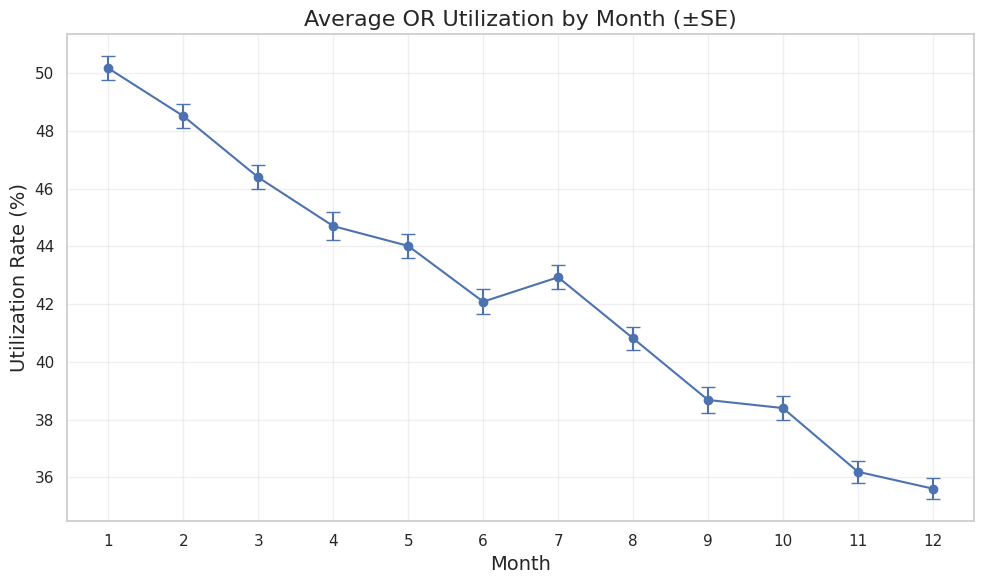

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ensure daily_util is built from the original column
df_all["date"] = df_all["entry_dt"].dt.date

daily_util = (
    df_all[
        ["Actual Operating Room Number", "date", "daily_utilization_rate"]
    ]
    .drop_duplicates()
)

# extract month
daily_util["month"] = pd.to_datetime(daily_util["date"]).dt.month

# compute mean, std and count per month on the original column
monthly_stats = (
    daily_util
    .groupby("month")["daily_utilization_rate"]
    .agg(mean="mean", std="std", count="count")
)

# standard error
monthly_stats["se"] = monthly_stats["std"] / np.sqrt(monthly_stats["count"])

# plot with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(
    monthly_stats.index,
    monthly_stats["mean"],
    yerr=monthly_stats["se"],
    fmt='-o',
    capsize=5
)
plt.title("Average OR Utilization by Month (±SE)", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Utilization Rate (%)", fontsize=14)
plt.xticks(range(1, 13))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Check whether the monthly downward trend repeats itself every year, or whether it is a change over the years.

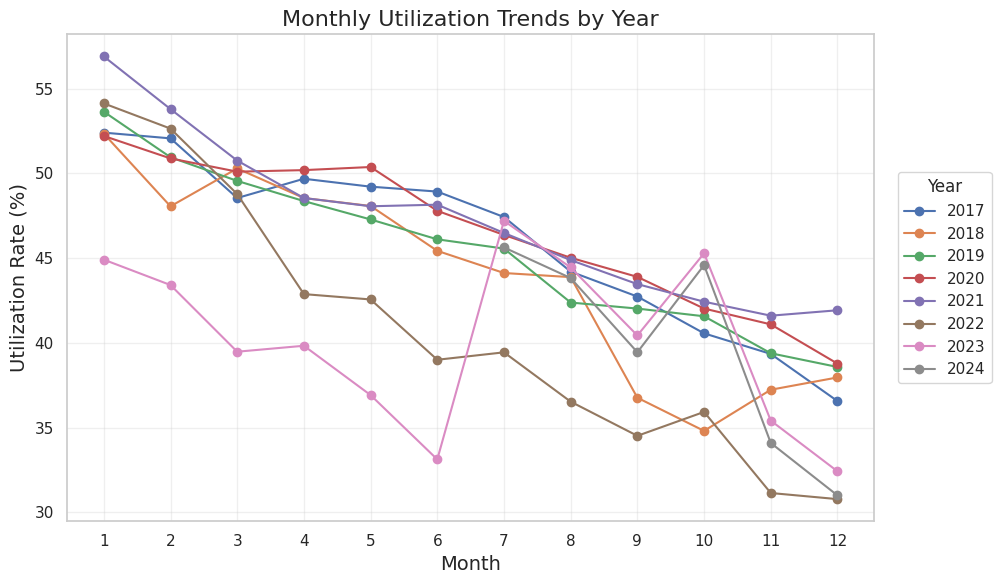

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# extract date and month
df_all["date"] = pd.to_datetime(df_all["entry_dt"]).dt.date
df_all["month"] = pd.to_datetime(df_all["date"]).dt.month

plt.figure(figsize=(12, 6))

# plot one line per year
for yr in sorted(df_all["year"].unique()):
    df_y = df_all[df_all["year"] == yr].copy()
    # compute per‐month mean of the original column
    monthly_mean = df_y.groupby("month")["daily_utilization_rate"].mean()
    plt.plot(
        monthly_mean.index,
        monthly_mean.values,
        marker="o",
        label=str(yr)
    )

plt.title("Monthly Utilization Trends by Year", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Utilization Rate (%)", fontsize=14)
plt.xticks(range(1, 13))
plt.legend(title="Year", bbox_to_anchor=(1.02, 0.5), loc="center left")
plt.grid(alpha=0.3)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

– Gives you separate graphs of the Trend (is utilization increasing cumulatively), the annual seasonality (if there are waves of load each particular month) and the residual.

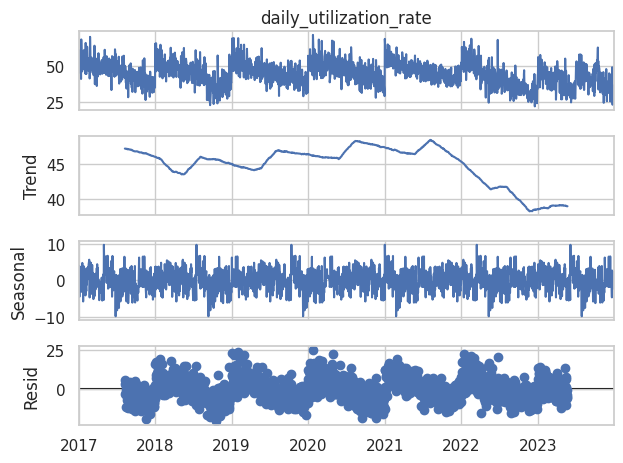

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Prepare time series of average daily utilization directly from the original column
ts = df_all.groupby("date")["daily_utilization_rate"].mean()
ts.index = pd.to_datetime(ts.index)

# Decompose into trend, seasonality and residuals
result = seasonal_decompose(ts, model="additive", period=365)

# Plot the decomposition
result.plot()
plt.tight_layout()
plt.show()

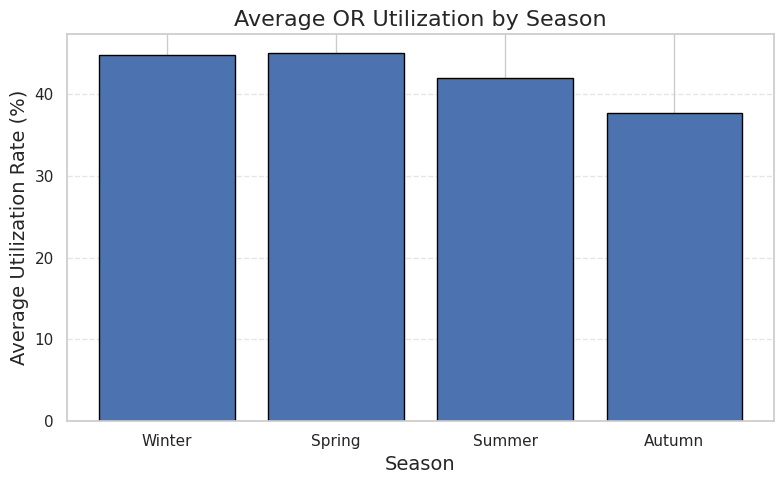

   season  daily_utilization_rate
0  Winter               44.760176
1  Spring               45.070160
2  Summer               41.942692
3  Autumn               37.640904


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure month column exists on your daily_util DataFrame
daily_util["month"] = pd.to_datetime(daily_util["date"]).dt.month

# Map month → season
def month_to_season(m):
    if m in [12, 1, 2]:
        return "Winter"
    elif m in [3, 4, 5]:
        return "Spring"
    elif m in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

daily_util["season"] = daily_util["month"].apply(month_to_season)

# Compute mean utilization by season, in logical order
seasonal_trend = (
    daily_util
    .groupby("season")["daily_utilization_rate"]
    .mean()
    .reindex(["Winter", "Spring", "Summer", "Autumn"])
    .reset_index()
)

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(seasonal_trend["season"], seasonal_trend["daily_utilization_rate"], edgecolor="black")
plt.title("Average OR Utilization by Season", fontsize=16)
plt.xlabel("Season", fontsize=14)
plt.ylabel("Average Utilization Rate (%)", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

print(seasonal_trend)

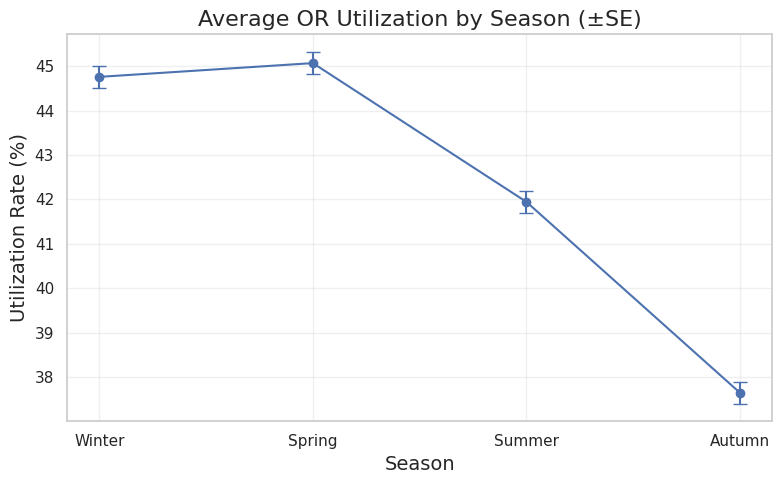

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ensure 'month' and 'season' are defined on daily_util
daily_util["month"] = pd.to_datetime(daily_util["date"]).dt.month

def month_to_season(m):
    if m in [12, 1, 2]:
        return "Winter"
    elif m in [3, 4, 5]:
        return "Spring"
    elif m in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

daily_util["season"] = daily_util["month"].apply(month_to_season)

# compute mean, std and count per season using the original column
season_stats = (
    daily_util
    .groupby("season")["daily_utilization_rate"]
    .agg(mean="mean", std="std", count="count")
    .reindex(["Winter", "Spring", "Summer", "Autumn"])
)

# standard error
season_stats["se"] = season_stats["std"] / np.sqrt(season_stats["count"])

# plot with error bars
plt.figure(figsize=(8, 5))
plt.errorbar(
    season_stats.index,
    season_stats["mean"],
    yerr=season_stats["se"],
    fmt='o-',
    capsize=5
)
plt.title("Average OR Utilization by Season (±SE)", fontsize=16)
plt.xlabel("Season", fontsize=14)
plt.ylabel("Utilization Rate (%)", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Allows you to identify whether there are extreme outliers, or seasons with a wider IQR (i.e. less stability).

<Figure size 800x600 with 0 Axes>

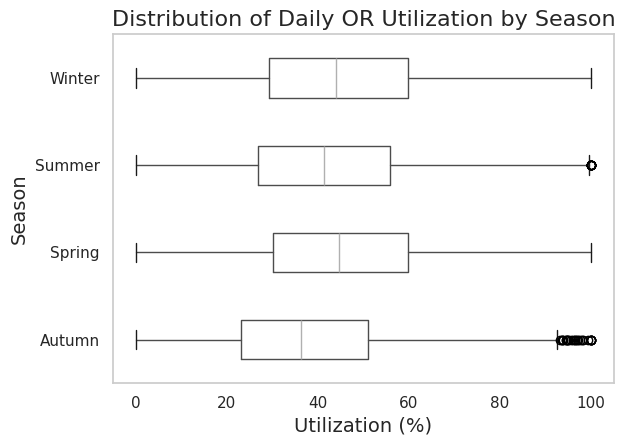

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
daily_util.boxplot(
    column="daily_utilization_rate",
    by="season",
    grid=False,
    vert=False
)
plt.title("Distribution of Daily OR Utilization by Season", fontsize=16)
plt.suptitle("")
plt.xlabel("Utilization (%)", fontsize=14)
plt.ylabel("Season", fontsize=14)
plt.tight_layout()
plt.show()

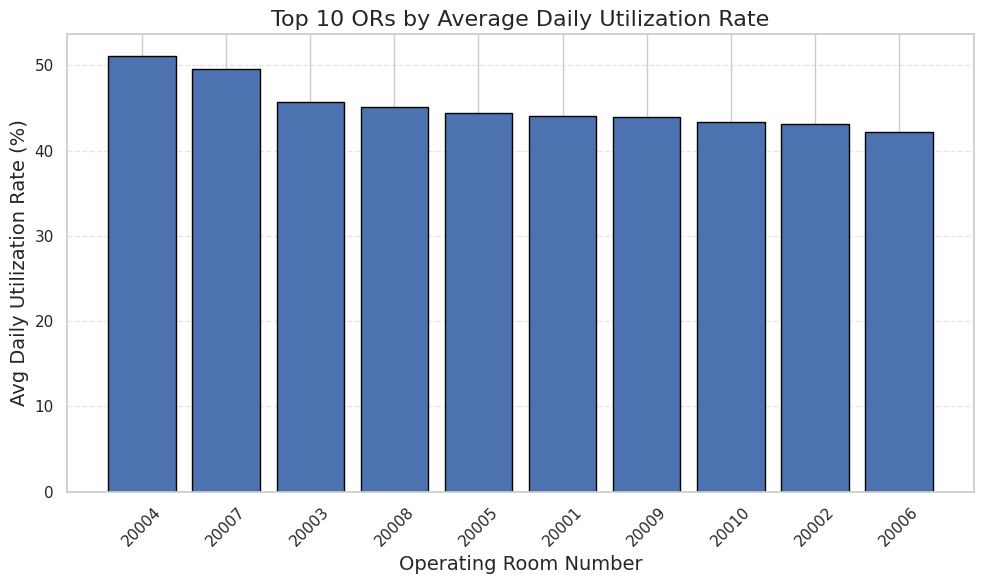

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path

file_pattern = "/content/*_data_with_UTR_F.xlsx"
files = glob(file_pattern)
df_list = []
for fp in files:
    year = int(Path(fp).stem.split("_")[0])
    df = pd.read_excel(fp)
    df["year"] = year
    df_list.append(df)
df_all = pd.concat(df_list, ignore_index=True, sort=False)

# Build a daily_util DataFrame using the original column
df_all["date"] = pd.to_datetime(
    df_all["Actual Surgery Room Entry Date"].astype(str) + " " +
    df_all["Actual Surgery Room Entry Time"].astype(str),
    errors="coerce"
).dt.date

daily_util = (
    df_all[
        ["Actual Operating Room Number", "date", "daily_utilization_rate"]
    ]
    .drop_duplicates()
)

# Compute the top-10 ORs by average daily utilization rate
or_usage = (
    daily_util
    .groupby("Actual Operating Room Number")["daily_utilization_rate"]
    .mean()
    .reset_index(name="avg_daily_util_rate")
    .sort_values("avg_daily_util_rate", ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
plt.bar(
    or_usage["Actual Operating Room Number"].astype(str),
    or_usage["avg_daily_util_rate"],
    edgecolor="black"
)
plt.title("Top 10 ORs by Average Daily Utilization Rate", fontsize=16)
plt.xlabel("Operating Room Number", fontsize=14)
plt.ylabel("Avg Daily Utilization Rate (%)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Check whether there are ORs that do few cases but take up long hours (long surgeries), or vice versa

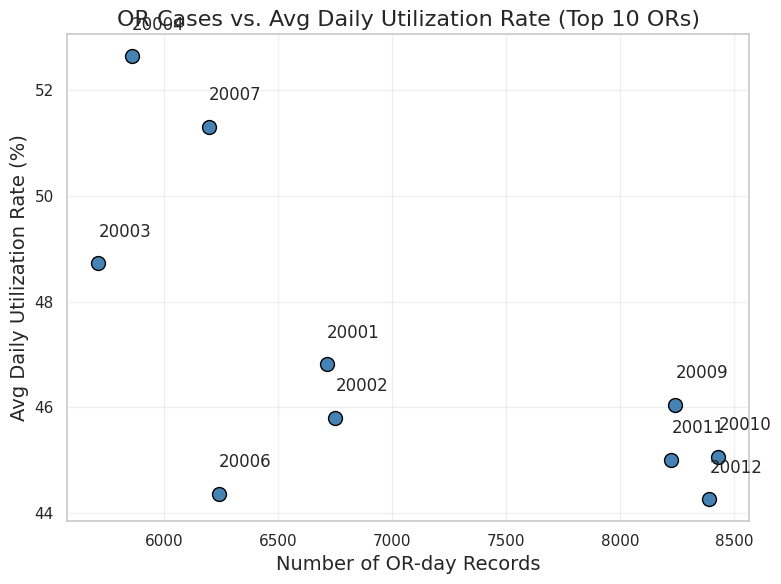

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

if "entry_dt" not in df_all.columns:
    df_all["entry_dt"] = pd.to_datetime(
        df_all["Actual Surgery Room Entry Date"].astype(str) + " " +
        df_all["Actual Surgery Room Entry Time"].astype(str),
        errors="coerce"
    )
if "date" not in df_all.columns:
    df_all["date"] = df_all["entry_dt"].dt.date

# Compute per-OR stats using the original utilization column
or_stats = (
    df_all
    .groupby("Actual Operating Room Number")
    .agg(
        total_days   = ("date", "nunique"),                    # number of distinct OR-days
        total_cases  = ("daily_utilization_rate", "count"),    # total OR-day records
        avg_util_rate= ("daily_utilization_rate", "mean")      # mean daily utilization %
    )
    .reset_index()
)

# Select top-10 ORs by total_days
top_or_list = or_stats.nlargest(10, "total_days")["Actual Operating Room Number"]
or_top10   = or_stats[or_stats["Actual Operating Room Number"].isin(top_or_list)]

# Number of Cases vs. Avg Daily Utilization Rate
plt.figure(figsize=(8, 6))
plt.scatter(
    or_top10["total_cases"],
    or_top10["avg_util_rate"],
    s=100,
    c="steelblue",
    edgecolor="black"
)

# Annotate each point with the OR number
for _, row in or_top10.iterrows():
    plt.text(
        row["total_cases"] + 1,
        row["avg_util_rate"] + 0.5,
        str(int(row["Actual Operating Room Number"])),
        fontsize=12
    )

plt.title("OR Cases vs. Avg Daily Utilization Rate (Top 10 ORs)", fontsize=16)
plt.xlabel("Number of OR-day Records", fontsize=14)
plt.ylabel("Avg Daily Utilization Rate (%)", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
mapping = pd.read_excel("/content/activity_codes_hg.xlsx").rename(columns={
    "קוד פעילות":           "Activity Code",
    "שם פעילות":           "Activity Name",
    "קוד סוג פעילות":      "Activity Type Code",
    "שם סוג פעילות":      "Activity Type Name",
})

# Ensure code columns are strings and stripped of whitespace
for col in ["Activity Code", "Activity Type Code"]:
    mapping[col] = mapping[col].astype(str).str.strip()
    df_all[col] = df_all[col].astype(str).str.strip()

# Subset mapping to the exact columns we need
mapping = mapping[
    ["Activity Code", "Activity Name", "Activity Type Code", "Activity Type Name"]
]

# Merge back into df_all on both code columns
df_all = df_all.merge(
    mapping,
    on=["Activity Code", "Activity Type Code"],
    how="left"
)

# check for any unmapped codes
unmapped = df_all[df_all["Activity Name"].isna()][["Activity Code", "Activity Type Code"]].drop_duplicates()
print(f"Unmapped activity codes:\n{unmapped}")

Unmapped activity codes:
      Activity Code Activity Type Code
0             26.33                 19
8             26.32                 19
10             26.3                 19
11            16.03                 39
12            81.54                 15
...             ...                ...
89848          76.4                 15
92650         29.83                  8
92651         29.77                  8
93266         29.62                  8
97916         49.12                 12

[519 rows x 2 columns]


In [ ]:
print(df_all.columns)

Index(['patient_id', 'Site Code', 'Main Surgeon Code', 'Activity Code',
       'Activity Type Code', 'Planned SU Time (Large/Medium/Small)',
       'Pre-Surgery Admission Date', 'Height', 'Weight',
       'Patient Age (on Surgery Day)', 'Background Diseases/Diagnoses',
       'Planned Surgery Date', 'Planned Surgery Time',
       'Surgery Admission Date', 'Administrative Admission Time',
       'Planned Operating Room Number',
       'Pre-Surgical Admission Time Before Surgery', 'Surgical Team Codes',
       'Anesthesiologist Code', 'Anesthesia Code', 'Type of Anesthesia',
       'Cancellation Reason on Surgery Day', 'Actual Operating Room Number',
       'Actual Surgery Room Entry Date', 'Actual Surgery Room Entry Time',
       'Incision Time', 'Closure Time', 'End of Surgery Date (Exit from OR)',
       'End of Surgery Time (Exit from OR)', 'Planned Surgery Duration',
       'Recovery Room Entry Date', 'Recovery Room Entry Time',
       'Recovery Room Exit Date', 'Recovery Room Exit 

In [ ]:
print(df_all.columns)
print(df_all["Activity Name"].head(10))
print("Non-null names:", df_all["Activity Name"].notna().sum())

Index(['patient_id', 'Site Code', 'Main Surgeon Code', 'Activity Code',
       'Activity Type Code', 'Planned SU Time (Large/Medium/Small)',
       'Pre-Surgery Admission Date', 'Height', 'Weight',
       'Patient Age (on Surgery Day)', 'Background Diseases/Diagnoses',
       'Planned Surgery Date', 'Planned Surgery Time',
       'Surgery Admission Date', 'Administrative Admission Time',
       'Planned Operating Room Number',
       'Pre-Surgical Admission Time Before Surgery', 'Surgical Team Codes',
       'Anesthesiologist Code', 'Anesthesia Code', 'Type of Anesthesia',
       'Cancellation Reason on Surgery Day', 'Actual Operating Room Number',
       'Actual Surgery Room Entry Date', 'Actual Surgery Room Entry Time',
       'Incision Time', 'Closure Time', 'End of Surgery Date (Exit from OR)',
       'End of Surgery Time (Exit from OR)', 'Planned Surgery Duration',
       'Recovery Room Entry Date', 'Recovery Room Entry Time',
       'Recovery Room Exit Date', 'Recovery Room Exit 

Unmapped codes (first 10): ['53.0' '81.0' '57.0' '15.0' '64.0' '54.0' '47.0' '55.0' '24.0' '84.0']
Mapped names: 89657 / 98422


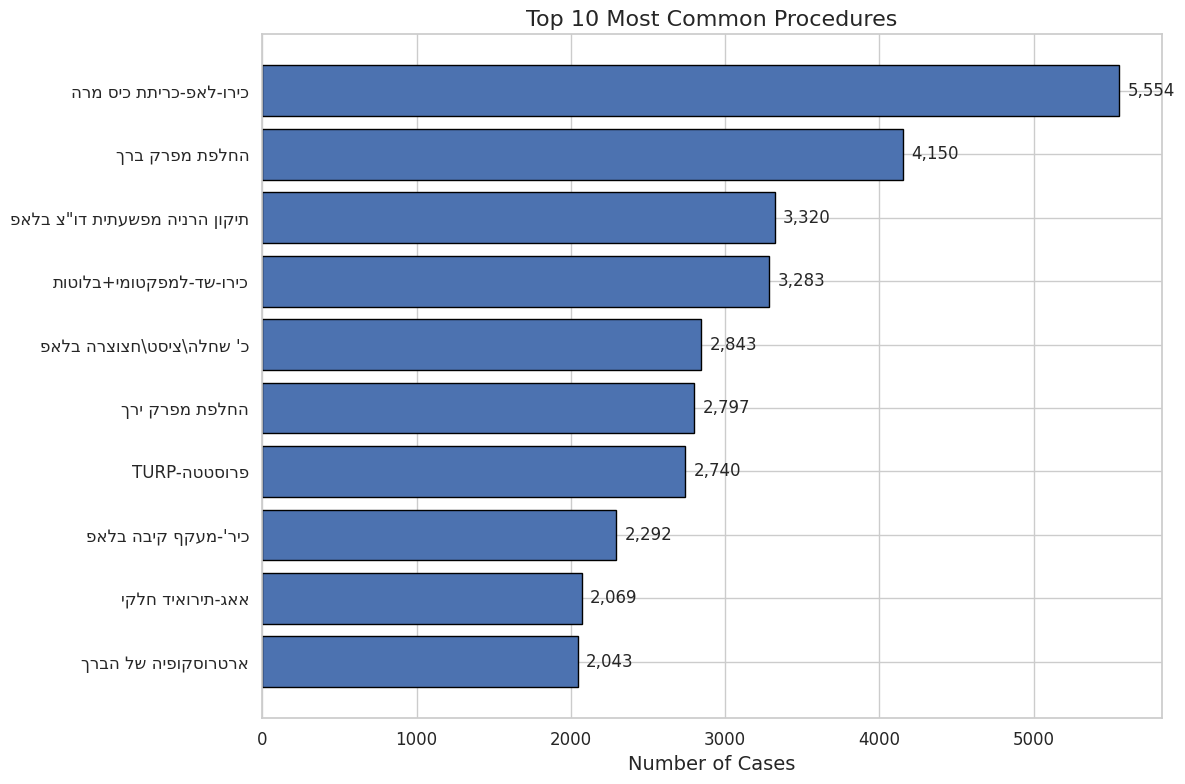

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from bidi.algorithm import get_display

df_all = pd.read_excel("/content/all_years_combined_with_global_ID.xlsx")
df_all.columns = df_all.columns.str.strip()

mapping = pd.read_excel("/content/activity_codes_hg.xlsx")

mapping = mapping.rename(columns={
    "קוד פעילות":           "Activity Code",
    "שם פעילות":          "Activity Name",
    "קוד סוג פעילות":      "Activity Type Code",
    "שם סוג פעילות":       "Activity Type Name",
})

mapping["Activity Code"]      = mapping["Activity Code"].astype(str).str.strip()
df_all["Activity Code"]       = df_all["Activity Code"].astype(str).str.strip()

df_all = df_all.merge(
    mapping[["Activity Code", "Activity Name"]],
    on="Activity Code",
    how="left"
)

missing = df_all[df_all["Activity Name"].isna()]["Activity Code"].unique()
print("Unmapped codes (first 10):", missing[:10])
print("Mapped names:", df_all["Activity Name"].notna().sum(), "/", len(df_all))

proc_counts = (
    df_all["Activity Name"]
      .dropna()
      .value_counts()
      .head(10)
)

labels = proc_counts.index.tolist()[::-1]
counts = proc_counts.values.tolist()[::-1]
labels_bidi = [get_display(lbl) for lbl in labels]

plt.figure(figsize=(12, 8))
bars = plt.barh(labels_bidi, counts, color="#4C72B0", edgecolor="black")

plt.title("Top 10 Most Common Procedures", fontsize=16)
plt.xlabel("Number of Cases", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, ha="right")

max_cnt = max(counts)
for bar, cnt in zip(bars, counts):
    plt.text(cnt + max_cnt*0.01,
             bar.get_y() + bar.get_height()/2,
             f"{cnt:,}",
             va="center",
             fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

if "date" not in df_all.columns:
    df_all["entry_dt"] = pd.to_datetime(
        df_all["Actual Surgery Room Entry Date"].astype(str) + " " +
        df_all["Actual Surgery Room Entry Time"].astype(str),
        errors="coerce"
    )
    df_all["date"] = df_all["entry_dt"].dt.date

# Build surgeon+team combo label
df_all["combo"] = (
    df_all["Main Surgeon Code"].astype(str) + " | " +
    df_all["Surgical Team Codes"].astype(str)
)

# Compute per-combo metrics on the original utilization column
combo_stats = (
    df_all
    .groupby("combo")["daily_utilization_rate"]
    .agg(
        avg_util_pct="mean",
        n_cases="count"
    )
    .reset_index()
)

# Define “high util” threshold at the 75th percentile
threshold = df_all["daily_utilization_rate"].quantile(0.75)

# Count high-util days per combo
high_util_counts = (
    df_all[df_all["daily_utilization_rate"] >= threshold]
    .groupby("combo")
    .size()
    .reset_index(name="n_high_util_days")
)

# Merge back and fill zeros
combo_stats = (
    combo_stats
    .merge(high_util_counts, on="combo", how="left")
    .fillna({"n_high_util_days": 0})
)

# Filter to combos with at least 5 cases
combo_stats = combo_stats[combo_stats["n_cases"] >= 5]

# Sort and take top 10
top_combos = combo_stats.sort_values(
    ["n_high_util_days", "avg_util_pct"],
    ascending=[False, False]
).head(10)

# Display the key columns
top_combos[["combo", "n_cases", "avg_util_pct", "n_high_util_days"]]

,combo,n_cases,avg_util_pct,n_high_util_days
7055,"14615 | 121.0, 128.0, 14615.0, 174.0, 203.0, 3...",104,54.259057,46.0
32859,"23114 | 154.0, 23114.0, 308985035.0, 310599436...",64,56.313319,32.0
24068,"20044 | 20044.0, 299.0, 304951833.0, 317388460...",44,60.456219,25.0
23664,"20044 | 20044.0, 245.0, 299.0, 304951833.0, 31...",40,56.141561,21.0
9499,"15802 | 114304.0, 141.0, 15802.0, 312649254.0,...",31,58.186790,20.0
23721,"20044 | 20044.0, 245.0, 299.0, 312016306.0, 31...",21,64.457636,19.0
32075,"23095 | 20659.0, 23095.0, 300610003.0, 3457304...",54,51.153314,19.0
32074,"23095 | 20659.0, 23095.0, 300610003.0, 3457304...",52,51.364896,17.0
7067,"14615 | 121.0, 128.0, 14615.0, 174.0, 312071376.0",46,47.491303,16.0
23691,"20044 | 20044.0, 245.0, 299.0, 308237197.0, 31...",14,65.605469,13.0


Columns in df_all: ['patient_id', 'Site Code', 'Main Surgeon Code', 'Activity Code', 'Activity Type Code', 'Planned SU Time (Large/Medium/Small)', 'Pre-Surgery Patient File (External)', 'Pre-Surgery Admission Date', 'Height', 'Weight', 'Patient Age (on Surgery Day)', 'Background Diseases/Diagnoses', 'Planned Surgery Date', 'Planned Surgery Time', 'Surgery Admission Date', 'Administrative Admission Time', 'Planned Operating Room Number', 'Pre-Surgery Hospitalization Admission Date', 'Pre-Surgery Hospitalization Admission Time', 'Pre-Surgical Admission Time Before Surgery', 'Surgical Team Codes', 'Anesthesiologist Code', 'Anesthesia Code', 'Type of Anesthesia', 'Cancellation Reason on Surgery Day', 'Actual Operating Room Number', 'Actual Surgery Room Entry Date', 'Actual Surgery Room Entry Time', 'Incision Time', 'Closure Time', 'End of Surgery Date (Exit from OR)', 'End of Surgery Time (Exit from OR)', 'Planned Surgery Duration', 'Recovery Room Entry Date', 'Recovery Room Entry Time', '

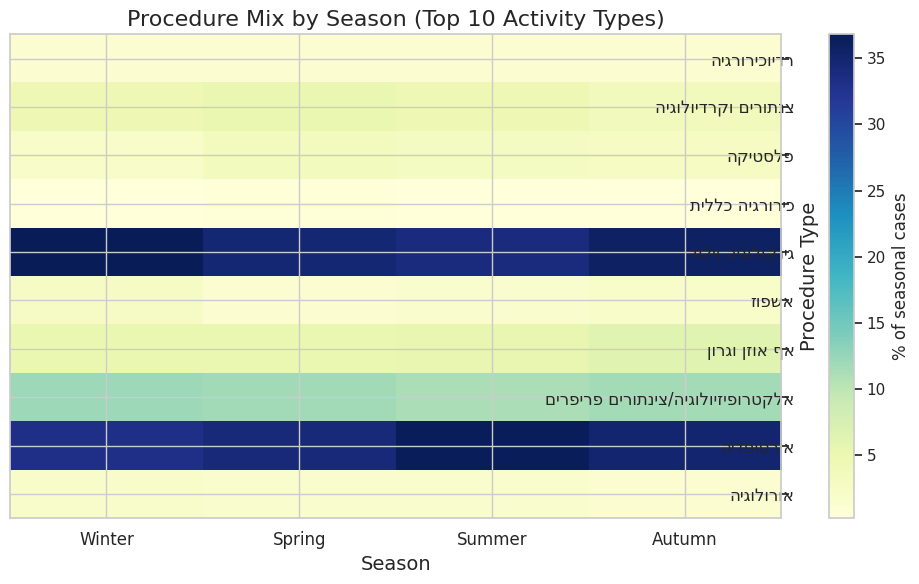

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from bidi.algorithm import get_display

df_all.columns = df_all.columns.str.strip()

df_all["entry_dt"] = pd.to_datetime(
    df_all["Actual Surgery Room Entry Date"].astype(str) + " " +
    df_all["Actual Surgery Room Entry Time"].astype(str),
    errors="coerce"
)
df_all["date"]  = df_all["entry_dt"].dt.date
df_all["month"] = pd.to_datetime(df_all["date"]).dt.month

def month_to_season(m):
    if m in [12, 1, 2]:
        return "Winter"
    elif m in [3, 4, 5]:
        return "Spring"
    elif m in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df_all["season"] = df_all["month"].apply(month_to_season)

mapping = pd.read_excel("/content/activity_codes_hg.xlsx").rename(columns={
    "קוד פעילות":       "Activity Code",
    "שם סוג פעילות":    "Activity Type Name",
})

mapping["Activity Code"]     = mapping["Activity Code"].astype(str).str.strip()
df_all["Activity Code"]      = df_all["Activity Code"].astype(str).str.strip()

df_all = df_all.merge(
    mapping[["Activity Code", "Activity Type Name"]],
    on="Activity Code",
    how="left"
)

print("Columns in df_all:", df_all.columns.tolist())
print("Non-null Activity Type Name:", df_all["Activity Type Name"].notna().sum())

season_counts = (
    df_all
    .groupby(["season", "Activity Type Name"])
    .size()
    .reset_index(name="case_count")
)

season_totals = season_counts.groupby("season")["case_count"].transform("sum")
season_counts["pct_of_season"] = season_counts["case_count"] / season_totals * 100

top10 = df_all["Activity Type Name"].value_counts().nlargest(10).index
heatmap_data = (
    season_counts[season_counts["Activity Type Name"].isin(top10)]
    .pivot(index="Activity Type Name", columns="season", values="pct_of_season")
    .reindex(columns=["Winter", "Spring", "Summer", "Autumn"])
    .fillna(0)
)

labels_bidi = [get_display(lbl) for lbl in heatmap_data.index]

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(heatmap_data, aspect="auto", cmap="YlGnBu", origin="lower")
fig.colorbar(im, ax=ax, label="% of seasonal cases")

ax.set_xticks(range(heatmap_data.shape[1]))
ax.set_xticklabels(heatmap_data.columns, fontsize=12)
ax.set_yticks(range(len(labels_bidi)))
ax.set_yticklabels(labels_bidi, fontsize=12, ha="right")
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax.set_xlabel("Season", fontsize=14)
ax.set_ylabel("Procedure Type", fontsize=14)
ax.set_title("Procedure Mix by Season (Top 10 Activity Types)", fontsize=16)

plt.tight_layout()
plt.show()